<a href="https://colab.research.google.com/github/athxri/MSC/blob/main/PROJECT_BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e9a6e73944a957a50e75a1d395ed80b083143cbcee5bf052f7540ce0f410934e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.1 MB/s eta 0:00:00


In [3]:
!pip install geopandas

In [4]:
!pip install pathlib

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import firebase_admin
from firebase_admin import credentials, firestore
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql import types as T
from google.cloud import language_v1
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.context import SparkContext, SparkConf
import nltk
nltk.download('vader_lexicon')
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import geopandas as gpd
from pathlib import Path


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Load Data to  Firestore

First we imported the data as a pandas dataframe

In [ ]:
# Loading the .csv file
csv_file_path = r'C:\Users\xrist\Desktop\MSc\Big Data\Project\sentiment140\training.1600000.processed.noemoticon.csv'

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

# Read CSV data into a pandas DataFrame
df = pd.read_csv(csv_file_path, encoding = "ISO-8859-1", names=DATASET_COLUMNS)
df.head()

In [ ]:
# Number of smaller datasets
num_datasets = 100

# Calculate the number of rows in each smaller dataset
rows_per_dataset = len(df) // num_datasets

# Use numpy.array_split to split the DataFrame into a list of smaller DataFrames
smaller_datasets = np.array_split(df, num_datasets)

# Save each smaller DataFrame to a separate CSV file
for i, dataset in enumerate(smaller_datasets):
    dataset.to_csv(f'smaller_dataset_{i + 1}.csv', index=False)

The above was needed as when trying to load the whole dataset at once to firestore proved to be impossible, since our notebook ran into errors.

In [ ]:
cred = credentials.Certificate("/content/sentiment-analysis-407917-14517f26048a.json")
#firebase_admin.initialize_app(cred)


db = firestore.client()

# Name of firestore collection to store the data
collection_name = 'tweets'

# Create documents in Firestore for each row in the specified range of datasets
for i, dataset in enumerate(smaller_datasets[90:92], start=91):
    # Convert the smaller dataset to a list of dictionaries
    data_list = dataset.to_dict(orient='records')

    # Create documents in Firestore for each row in the smaller dataset
    for row in data_list:

        # Create a document in Firestore for each row
        doc_ref = db.collection(collection_name).add({
            "target": row["target"],
            "ids": row["ids"],
            "date": row["date"],
            "flag": row["flag"],
            "user": row["user"],
            "text": row["text"]
        })

        print(f"Document added with ID: {doc_ref[1].id}")

Next up we loaded the 2020 election tweets for Trump and Biden

In [ ]:
# Columns to keep in the DataFrame
columns_to_keep = ['created_at', 'tweet', 'country', 'state']

# Read CSV with specific columns
biden_df = pd.read_csv('hashtag_joebiden.csv', usecols=columns_to_keep, nrows=100000)

# Specify the desired data types for each column
column_data_types = {
    'created_at': 'str',
    'tweet': 'str',
    'country': 'str',
    'state': 'str'
}
# Trump data were problematic(?) so to load them we had to split them into chunks, this was the only way to load them

# Read CSV in chunks with specific columns, specified data types, and limit to the first 100.000 rows
chunk_size = 100  # Adjust the chunk size based on your preferences
trump_chunks = pd.read_csv('hashtag_donaldtrump.csv', usecols=columns_to_keep, dtype=column_data_types, chunksize=chunk_size, nrows=100000)

# Concatenate the first 100000 rows from the chunks into a single DataFrame
trump_df = pd.concat(trump_chunks, ignore_index=True)

# Adding a column to specify who the tweet is about
trump_df['about'] = 'Trump'
biden_df['about'] = 'Biden'

# Concatenate the two DataFrames vertically
election_tweets_df = pd.concat([biden_df, trump_df], ignore_index=True)

cred = credentials.Certificate("/content/sentiment-analysis-407917-14517f26048a.json")
#firebase_admin.initialize_app(cred)


db = firestore.client()

# Replace with your collection name
collection_name = "election_tweets"

# Replace with the path to your CSV file
csv_file_path = r'C:\Users\xrist\Desktop\MSc\Big Data\Project\election_tweets.csv'

# Read CSV file and upload data to Firestore
with open(csv_file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=['created_at', 'tweet', 'country', 'state', 'about'])
    next(reader)  # Skip the header row

    # Counter variable to keep track of the document number
    document_number = 1

    for row in reader:
        # Create a document in Firestore for each row
        doc_ref = db.collection(collection_name).add({
            "created_at": row["created_at"],
            "tweet": row["tweet"],
            "country": row["country"],
            "state": row["state"],
            "about": row["about"]
        })

        print(f"Document {document_number} added with ID: {doc_ref[1].id}")

        # Increment the document number for the next iteration
        document_number += 1



## Fetch data from Firestore

You will need to replace the path below with the path of the .json file i sent you in order to run it.

In [8]:
%env GOOGLE_APPLICATION_CREDENTIALS=/content/sentiment-analysis-407917-14517f26048a.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/sentiment-analysis-407917-14517f26048a.json


In [9]:
# Initialize Firestore client
db = firestore.Client()

# Name of the Firestore collection
collection_name = 'tweets'

# Create a reference to the collection
collection_ref = db.collection(collection_name)

# Initialize an empty list to store documents
data = []

# Batch size for querying
batch_size = 20000
# Cursor to paginate through the collection
cursor = None

# Initial query to start the loop
query = collection_ref.limit(batch_size)
docs = query.stream()

while True:
    for doc in docs:
        doc_data = doc.to_dict()
        data.append(doc_data)

    print(f"Processed {len(data)} documents. Updating cursor.")

    # Check if there are no more documents or if the desired count is reached
    if len(data) == 560612:
        break

    # Update the cursor for the next batch
    cursor = doc

    # Query the next batch using the updated cursor
    query = collection_ref.limit(batch_size).start_after(cursor)
    docs = query.stream()

# Create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Print or use the DataFrame as needed
print(df.shape)

Processed 20000 documents. Updating cursor.
Processed 40000 documents. Updating cursor.
Processed 60000 documents. Updating cursor.
Processed 80000 documents. Updating cursor.
Processed 100000 documents. Updating cursor.
Processed 120000 documents. Updating cursor.
Processed 140000 documents. Updating cursor.
Processed 160000 documents. Updating cursor.
Processed 180000 documents. Updating cursor.
Processed 200000 documents. Updating cursor.
Processed 220000 documents. Updating cursor.
Processed 240000 documents. Updating cursor.
Processed 260000 documents. Updating cursor.
Processed 280000 documents. Updating cursor.
Processed 300000 documents. Updating cursor.
Processed 320000 documents. Updating cursor.
Processed 340000 documents. Updating cursor.
Processed 360000 documents. Updating cursor.
Processed 380000 documents. Updating cursor.
Processed 400000 documents. Updating cursor.
Processed 420000 documents. Updating cursor.
Processed 440000 documents. Updating cursor.
Processed 4600

In [10]:
# Initialize Spark session
spark = SparkSession.builder.appName("TweetAnalysis").getOrCreate()

# Create a Spark DataFrame with the defined schema
tweets_df = spark.createDataFrame(df)

# Perform text preprocessing
preprocessed_df = tweets_df.withColumn("processed_text", lower(regexp_replace(col("text"), "[^a-zA-Z0-9\\s]", "")))

# Sentiment analysis function using VADER
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)["compound"]
    return sentiment_score

# Define a Spark UDF for sentiment analysis
sentiment_udf = udf(analyze_sentiment_vader, FloatType())

# Apply sentiment analysis to the DataFrame
analyzed_df = preprocessed_df.withColumn("sentiment", sentiment_udf(col("processed_text")))

In [11]:
analyzed_df.show()

+--------------------+---------------+--------+------+--------------------+-------------+--------------------+---------+
|                date|           user|    flag|target|                text|          ids|      processed_text|sentiment|
+--------------------+---------------+--------+------+--------------------+-------------+--------------------+---------+
|Mon Jun 01 16:49:...|    therealcaro|NO_QUERY|   4.0|@dgtized yeah--Wa...|1.997427626E9|dgtized yeahwalt ...|   0.8402|
|Wed Jun 03 06:52:...|        zarap13|NO_QUERY|   4.0|@CrunchyK  Oh NO ...|2.016498404E9|crunchyk  oh no t...|  -0.4874|
|Fri May 29 00:29:...|            vsr|NO_QUERY|   4.0|trying out @aravi...|1.957435535E9|trying out aravin...|   0.3182|
|Mon May 04 04:32:...|     JanaWester|NO_QUERY|   0.0|Real quick?! Sitt...|1.694901142E9|real quick sittin...|  -0.4927|
|Sun Jun 07 02:16:...|      thesp0nge|NO_QUERY|   4.0|@beppeg There is ...| 2.06334145E9|beppeg there is n...|   -0.296|
|Tue Jun 16 03:55:...|    moktel

In [12]:
# Register the Spark DataFrame as a temporary SQL table
analyzed_df.createOrReplaceTempView("tweets_table")

# Increase the number of rows displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 100)

# Set the column width for the 'text' column
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)

# Run SQL queries on the Spark DataFrame
query_result = spark.sql("SELECT processed_text, sentiment FROM tweets_table WHERE sentiment >0.9")

# Show the result of the query
query_result.show(50, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+---------+
|processed_text                                                                                                                       |sentiment|
+-------------------------------------------------------------------------------------------------------------------------------------+---------+
|helenabaert green cover green ball is the best  its the most natural i think  good luck with it                                      |0.9168   |
|pink hey pink i loove your songs and quotso whatquot is so good  success girl kisses from brazil                                     |0.9005   |
|sean8412 hi sean i am glad that you liked the picture  theres about 100 more on there i hope u have a great day thank you bye        |0.936    |
|god wish i was 18  this lokks like a nice day to be sat in park with ma m8s drinkin haha lol                               

Performing sentiment analysis also on the pandas df for EDA

**!!! THIS WILL TAKE A LONG TIME TO RUN**

In [16]:
# Perform text preprocessing (replace with your own preprocessing logic)
df['processed_text'] = df['text'].str.lower().replace("[^a-zA-Z0-9\\s]", "", regex=True)

# Handle missing values in the 'processed_text' column
df['processed_text'] = df['processed_text'].fillna('')  # Replace NaN with an empty string

# Sentiment analysis function using VADER
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)["compound"]
    return sentiment_score

# Apply sentiment analysis to the DataFrame
tqdm.pandas()  # Enable progress_apply
df['sentiment'] = df['processed_text'].progress_apply(analyze_sentiment_vader)

# Show the analyzed DataFrame
df[['text', 'sentiment']]

100%|██████████| 560612/560612 [2:20:59<00:00, 66.27it/s]


,text,sentiment
0,@dgtized yeah--Walt Kelly is hilarious and fab...,0.8402
1,@CrunchyK Oh NO thats not cool at all....Drin...,-0.4874
2,trying out @aravindavk's http://bit.ly/chelvi ...,0.3182
3,Real quick?! Sitting in between heaven and hel...,-0.4927
4,@beppeg There is no &quot;too much&quot; when ...,-0.2960
...,...,...
560607,I have a sore throat,-0.3612
560608,Ughhh up for work but I would rather lay in be...,0.0000
560609,@ddlovato i cant sleep either Time change? whe...,0.4588
560610,The sun is wonderfullll,0.0000


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/MSc/tweets_df.csv')
#df.head()

,flag,ids,target,user,date,text,processed_text,sentiment
0,NO_QUERY,1.997428e+09,4.0,therealcaro,Mon Jun 01 16:49:56 PDT 2009,@dgtized yeah--Walt Kelly is hilarious and fab...,dgtized yeahwalt kelly is hilarious and fabulo...,0.8402
1,NO_QUERY,2.016498e+09,4.0,zarap13,Wed Jun 03 06:52:57 PDT 2009,@CrunchyK Oh NO thats not cool at all....Drin...,crunchyk oh no thats not cool at alldrink a l...,-0.4874
2,NO_QUERY,1.957436e+09,4.0,vsr,Fri May 29 00:29:46 PDT 2009,trying out @aravindavk's http://bit.ly/chelvi ...,trying out aravindavks httpbitlychelvi php fra...,0.3182
3,NO_QUERY,1.694901e+09,0.0,JanaWester,Mon May 04 04:32:31 PDT 2009,Real quick?! Sitting in between heaven and hel...,real quick sitting in between heaven and hell ...,-0.4927
4,NO_QUERY,2.063341e+09,4.0,thesp0nge,Sun Jun 07 02:16:11 PDT 2009,@beppeg There is no &quot;too much&quot; when ...,beppeg there is no quottoo muchquot when you t...,-0.2960


Loading the election tweets from firestore

In [13]:
# Collection name for retrieval
collection_name = 'election_tweets'

# Create a reference to the collection
collection_ref = db.collection(collection_name)

# Initialize an empty list to store documents
data = []

# Batch size for querying
batch_size = 20000
# Cursor to iterate through the collection
cursor = None

# Initial query to start the loop
query = collection_ref.limit(batch_size)
docs = query.stream()

while True:
    for doc in docs:
        doc_data = doc.to_dict()
        data.append(doc_data)

    print(f"Processed {len(data)} documents. Updating cursor.")

    # Check if there are no more documents or if the desired count is reached
    if len(data) == 200000:
        break

    # Update the cursor for the next batch
    cursor = doc

    # Query the next batch using the updated cursor
    query = collection_ref.limit(batch_size).start_after(cursor)
    docs = query.stream()

# Create a Pandas DataFrame from the list of dictionaries
election_df = pd.DataFrame(data)

# Print or use the DataFrame as needed
print(election_df.shape)

Processed 20000 documents. Updating cursor.
Processed 40000 documents. Updating cursor.
Processed 60000 documents. Updating cursor.
Processed 80000 documents. Updating cursor.
Processed 100000 documents. Updating cursor.
Processed 120000 documents. Updating cursor.
Processed 140000 documents. Updating cursor.
Processed 160000 documents. Updating cursor.
Processed 180000 documents. Updating cursor.
Processed 200000 documents. Updating cursor.
(200000, 5)


In [14]:
election_df.head(10)

,created_at,state,country,about,tweet
0,2020-10-18 22:33:24,,,Biden,Why is America being run by the Trump Family. ...
1,2020-10-17 13:41:23,,,Trump,"#Trump: ""You always do this. You’ve done this ..."
2,2020-10-21 22:07:01,,,Biden,Dinesh D'Souza Goes There: Joe Biden's Pawing ...
3,2020-10-18 19:43:56,,,Trump,"The least importnat, that which you can't meme..."
4,2020-10-17 18:03:04,,,Trump,#libya #sirte #syria #turquie #turkey #Trump20...
5,2020-10-15 09:35:11,,,Trump,Avete mai visto insieme Donald Trump e Patrizi...
6,2020-10-22 14:07:59,Texas,United States of America,Biden,#ChinaBitchBiden #JoeBiden https://t.co/1eDC8C...
7,2020-10-18 18:53:01,,,Trump,@YearntokenF \n\n$ YELD $ ETH $ TRX $ YLAND $ ...
8,2020-10-16 20:23:35,California,United States of America,Biden,"In dueling town halls, #Biden command counter..."
9,2020-10-22 15:13:33,District of Columbia,United States of America,Biden,"Harris, prominent Democrats listed as 'key con..."


In [15]:
# Create a Spark DataFrame with the defined schema
election_tweets_df = spark.createDataFrame(election_df)

# Perform text preprocessing
preprocessed_tweets_df = election_tweets_df.withColumn("processed_text", lower(regexp_replace(col("tweet"), "[^a-zA-Z0-9\\s]", "")))



# Define a Spark UDF for sentiment analysis
sentiment_udf = udf(analyze_sentiment_vader, FloatType())

# Apply sentiment analysis to the DataFrame
analyzed_tweets_df = preprocessed_tweets_df.withColumn("sentiment", sentiment_udf(col("processed_text")))
analyzed_tweets_df.show()

+-------------------+--------------------+--------------------+-----+--------------------+--------------------+---------+
|         created_at|               state|             country|about|               tweet|      processed_text|sentiment|
+-------------------+--------------------+--------------------+-----+--------------------+--------------------+---------+
|2020-10-18 22:33:24|                    |                    |Biden|Why is America be...|why is america be...|   0.0772|
|2020-10-17 13:41:23|                    |                    |Trump|#Trump: "You alwa...|trump you always ...|  -0.3818|
|2020-10-21 22:07:01|                    |                    |Biden|Dinesh D'Souza Go...|dinesh dsouza goe...|  -0.0772|
|2020-10-18 19:43:56|                    |                    |Trump|The least importn...|the least importn...|   0.6497|
|2020-10-17 18:03:04|                    |                    |Trump|#libya #sirte #sy...|libya sirte syria...|      0.0|
|2020-10-15 09:35:11|   

Performing sentiment analysis on the pandas tweets df for EDA

**!!! SAME AS BEFORE THIS WILL TAKE A LONG TIME TO RUN !!!**

In [ ]:
# Perform text preprocessing (replace with your own preprocessing logic)
election_df['processed_text'] = election_df['tweet'].str.lower().replace("[^a-zA-Z0-9\\s]", "", regex=True)

# Handle missing values in the 'processed_text' column
election_df['processed_text'] = election_df['processed_text'].fillna('')  # Replace NaN with an empty string

# Apply sentiment analysis to the DataFrame
tqdm.pandas()  # Enable progress_apply
election_df['sentiment'] = election_df['processed_text'].progress_apply(analyze_sentiment_vader)

# Show the analyzed DataFrame
election_df[['tweet', 'sentiment']]

100%|██████████| 200000/200000 [52:08<00:00, 63.93it/s]


,tweet,sentiment
0,Why is America being run by the Trump Family. ...,0.0772
1,"#Trump: ""You always do this. You’ve done this ...",-0.3818
2,Dinesh D'Souza Goes There: Joe Biden's Pawing ...,-0.0772
3,"The least importnat, that which you can't meme...",0.6497
4,#libya #sirte #syria #turquie #turkey #Trump20...,0.0000
...,...,...
199995,#Trump basically accusing hospital staff of se...,-0.6124
199996,Did anyone of you guys tried to swallow the im...,0.4939
199997,@kayleighmcenany You know who else is against ...,0.8555
199998,#Trump believes that Osama bin Landen is alive...,-0.2263


In [ ]:
election_df[['tweet', 'sentiment']]

,tweet,sentiment
0,Why is America being run by the Trump Family. ...,0.0772
1,"#Trump: ""You always do this. You’ve done this ...",-0.3818
2,Dinesh D'Souza Goes There: Joe Biden's Pawing ...,-0.0772
3,"The least importnat, that which you can't meme...",0.6497
4,#libya #sirte #syria #turquie #turkey #Trump20...,0.0000
...,...,...
199995,#Trump basically accusing hospital staff of se...,-0.6124
199996,Did anyone of you guys tried to swallow the im...,0.4939
199997,@kayleighmcenany You know who else is against ...,0.8555
199998,#Trump believes that Osama bin Landen is alive...,-0.2263


## Exploration

Reminder:
- df is the dataframe with the general tweets
- election_df is the dataframe with the 2020 US Presidential election tweets

### General tweets EDA

In [17]:
# We will split the sentiment into clusters as shown below
conditions = [
    (df['sentiment'] >= -1.0) & (df['sentiment'] <= -0.7),
    (df['sentiment'] > -0.7) & (df['sentiment'] <= -0.1),
    (df['sentiment'] > -0.1) & (df['sentiment'] <= 0.1),
    (df['sentiment'] > 0.1) & (df['sentiment'] <= 0.7),
    (df['sentiment'] > 0.7) & (df['sentiment'] <= 1.0)
]

values = ['strong negative', 'negative','neutral','positive','strong positive']
# Create a new column 'new_column' based on conditions
df['sentiment_clusters'] = np.select(conditions, values, default='')

In [18]:
df.drop(['target','flag','ids','user'],axis=1,inplace=True)
df.head()

,date,text,processed_text,sentiment,sentiment_clusters
0,Mon Jun 01 16:49:56 PDT 2009,@dgtized yeah--Walt Kelly is hilarious and fab...,dgtized yeahwalt kelly is hilarious and fabulo...,0.8402,strong positive
1,Wed Jun 03 06:52:57 PDT 2009,@CrunchyK Oh NO thats not cool at all....Drin...,crunchyk oh no thats not cool at alldrink a l...,-0.4874,negative
2,Fri May 29 00:29:46 PDT 2009,trying out @aravindavk's http://bit.ly/chelvi ...,trying out aravindavks httpbitlychelvi php fra...,0.3182,positive
3,Mon May 04 04:32:31 PDT 2009,Real quick?! Sitting in between heaven and hel...,real quick sitting in between heaven and hell ...,-0.4927,negative
4,Sun Jun 07 02:16:11 PDT 2009,@beppeg There is no &quot;too much&quot; when ...,beppeg there is no quottoo muchquot when you t...,-0.2960,negative


In [19]:
df.head()

,date,text,processed_text,sentiment,sentiment_clusters
0,Mon Jun 01 16:49:56 PDT 2009,@dgtized yeah--Walt Kelly is hilarious and fab...,dgtized yeahwalt kelly is hilarious and fabulo...,0.8402,strong positive
1,Wed Jun 03 06:52:57 PDT 2009,@CrunchyK Oh NO thats not cool at all....Drin...,crunchyk oh no thats not cool at alldrink a l...,-0.4874,negative
2,Fri May 29 00:29:46 PDT 2009,trying out @aravindavk's http://bit.ly/chelvi ...,trying out aravindavks httpbitlychelvi php fra...,0.3182,positive
3,Mon May 04 04:32:31 PDT 2009,Real quick?! Sitting in between heaven and hel...,real quick sitting in between heaven and hell ...,-0.4927,negative
4,Sun Jun 07 02:16:11 PDT 2009,@beppeg There is no &quot;too much&quot; when ...,beppeg there is no quottoo muchquot when you t...,-0.2960,negative


Wi will plot 6 wordclouds for the sentiment clusters, the idea is to check the which words appear the most in each of them, to do that we need to remove stopwords on the processed_text column

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


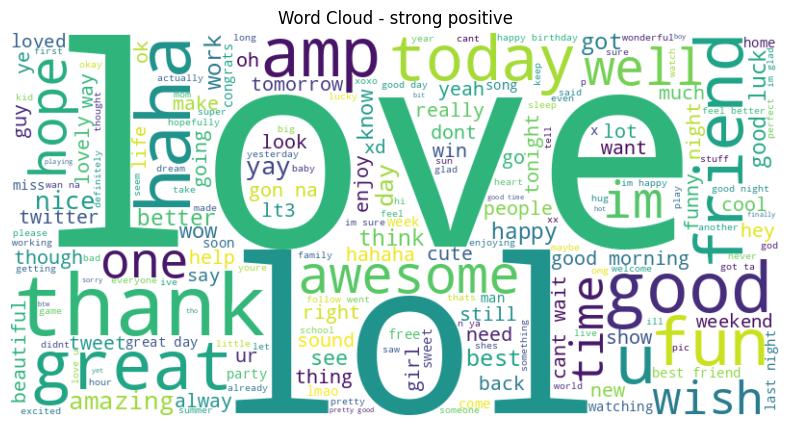

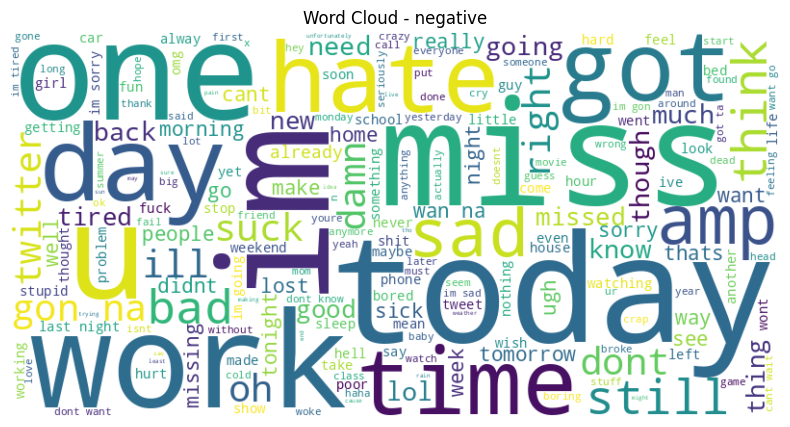

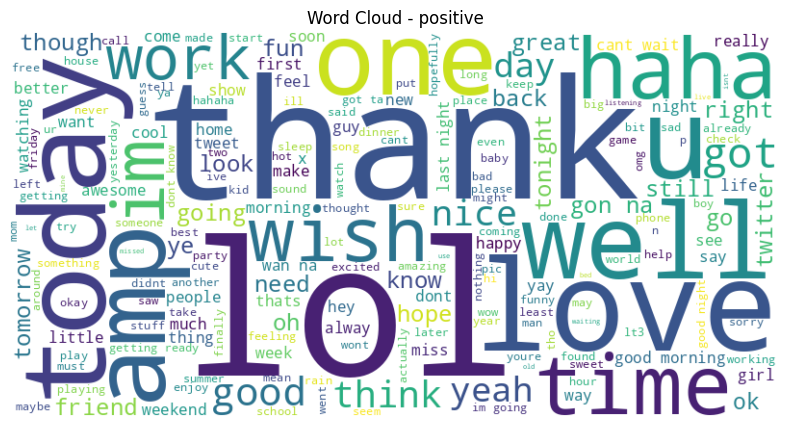

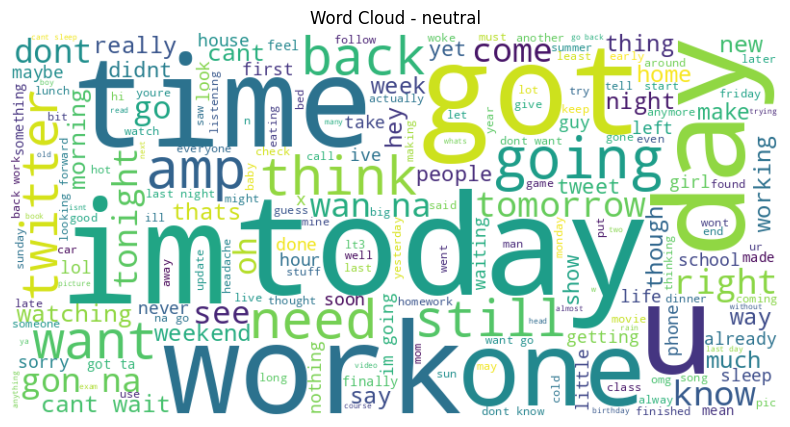

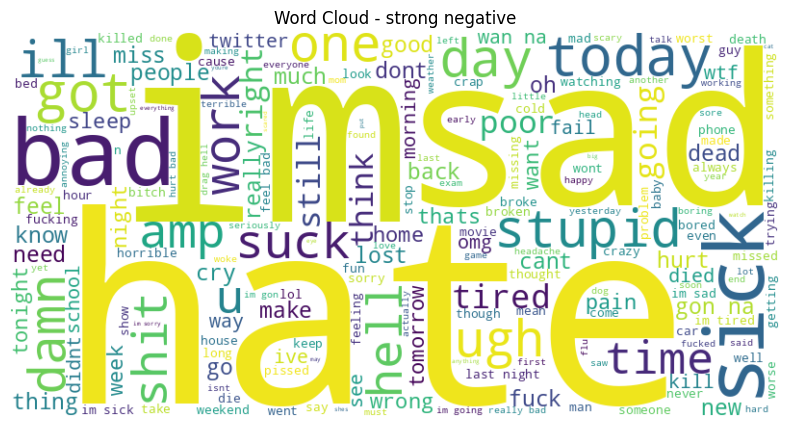

In [20]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocess text
def preprocess_text(text):
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return " ".join(lemmatized_words)

# Apply preprocessing to the processed_text column
df['processed_text_2'] = df['processed_text'].apply(preprocess_text)

# Function to generate and plot word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each sentiment cluster
for cluster in df['sentiment_clusters'].unique():
    cluster_text = " ".join(df[df['sentiment_clusters'] == cluster]['processed_text_2'])
    generate_wordcloud(cluster_text, f"Word Cloud - {cluster}")

So the strong positive, strong negative and neutral wordclouds seem to be classified correctly. As we can see words like hate and bad are included on the strong negative plot and words like love, good and great are classified as strong positive!

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


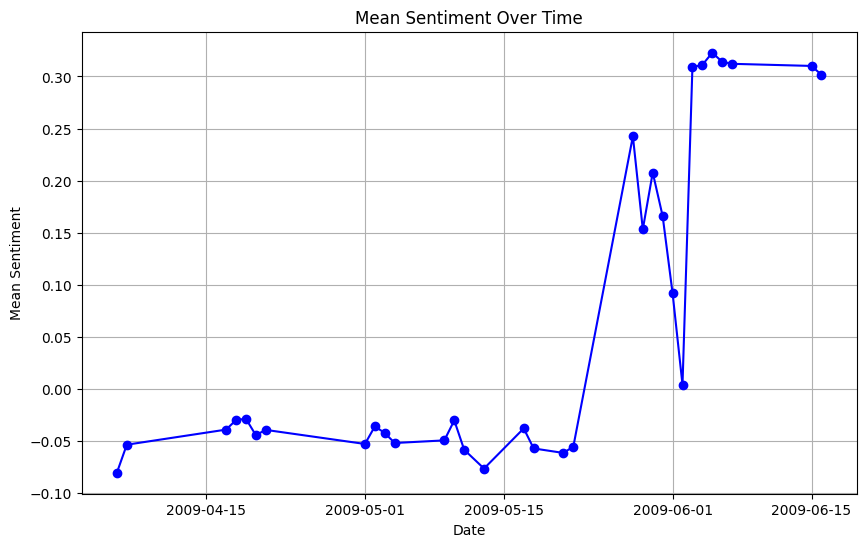

In [21]:
# Convert date for plotting
df['date'] = pd.to_datetime(df['date'])

# Group by date and calculate the mean sentiment
mean_sentiment_over_time = df.groupby(df['date'].dt.date)['sentiment'].mean()

# Plot the mean sentiment over time
plt.figure(figsize=(10, 6))
mean_sentiment_over_time.plot(kind='line', marker='o', color='blue')
plt.title('Mean Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment')
plt.grid(True)
plt.show()

It looks like the mean sentiment spikes after the second half of May 2019. Now lets see how many tweets each cluster contains

In [22]:
# Tweets per sentiment cluster
sentiment_counts = df['sentiment_clusters'].value_counts()

print(sentiment_counts)

positive           186492
neutral            169221
negative           115498
strong positive     72399
strong negative     17002
Name: sentiment_clusters, dtype: int64


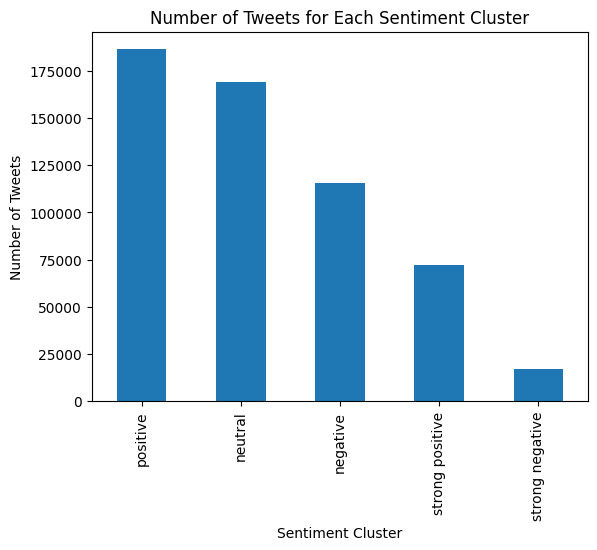

In [23]:
# Plotting the counts
sentiment_counts.plot(kind='bar')
plt.title('Number of Tweets for Each Sentiment Cluster')
plt.xlabel('Sentiment Cluster')
plt.ylabel('Number of Tweets')
plt.show()

Most of the tweets are positive and then neutral.

In [ ]:
import re

# Filter rows containing the word '2012'
movie_rows = df[df['processed_text_2'].str.contains(r'\borphan\b', case=False, na=False, regex=True)]

# Display the resulting DataFrame
movie_rows

,date,text,processed_text,sentiment,sentiment_clusters,processed_text_2
101480,Fri May 29 10:51:50 PDT 2009,wow! Leonardo DiCaprio and Jennifer Davisson K...,wow leonardo dicaprio and jennifer davisson ki...,0.5859,positive,wow leonardo dicaprio jennifer davisson killor...
127492,Sun Jun 07 02:49:57 PDT 2009,@whitsundays hmmm... 3 orphans and an eccentri...,whitsundays hmmm 3 orphans and an eccentric ex...,0.1027,positive,whitsunday hmmm 3 orphan eccentric explorer we...
128067,Sun May 03 23:50:22 PDT 2009,Not fun having your orphan getting through the...,not fun having your orphan getting through the...,-0.5109,negative,fun orphan getting battleground take forever g...
257330,Sat May 30 23:35:55 PDT 2009,I wanna watch &quot;Up&quot;. and when it com...,i wanna watch quotupquot and when it comes ou...,-0.2500,negative,wan na watch quotupquot come wan na watch band...
315993,Fri May 01 22:38:43 PDT 2009,Almost a #wow orphan matron. Lots of #pvp for ...,almost a wow orphan matron lots of pvp for me ...,0.5456,positive,almost wow orphan matron lot pvp tomorrow
414305,Sat May 30 13:30:20 PDT 2009,@NathanFillion Is a good cry or my husband is ...,nathanfillion is a good cry or my husband is a...,-0.5457,negative,nathanfillion good cry husband orphan dont wan...
437801,Fri May 29 20:07:24 PDT 2009,"Orphan Andrew: Jay Leno's last show, I am so S...",orphan andrew jay lenos last show i am so sad ...,0.7358,strong positive,orphan andrew jay lenos last show sad awesome ...
441898,Fri May 29 19:32:44 PDT 2009,Orphan Andrew: I caved in and made my own twit...,orphan andrew i caved in and made my own twitt...,0.0000,neutral,orphan andrew caved made twitter follow twitte...
466743,Sat May 30 23:35:23 PDT 2009,I wanna watch &quot;Up&quot;. and when it com...,i wanna watch quotupquot and when it comes ou...,-0.2500,negative,wan na watch quotupquot come wan na watch band...
517591,Sun May 03 23:50:22 PDT 2009,Not fun having your orphan getting through the...,not fun having your orphan getting through the...,-0.5109,negative,fun orphan getting battleground take forever g...


### Election tweets EDA

In [ ]:
conditions = [
    (election_df['sentiment'] >= -1.0) & (election_df['sentiment'] <= -0.7),
    (election_df['sentiment'] > -0.7) & (election_df['sentiment'] <= -0.1),
    (election_df['sentiment'] > -0.1) & (election_df['sentiment'] <= 0.1),
    (election_df['sentiment'] > 0.1) & (election_df['sentiment'] <= 0.7),
    (election_df['sentiment'] > 0.7) & (election_df['sentiment'] <= 1.0)
]

values = ['strong negative', 'negative','neutral','positive','strong positive']

election_df['sentiment_clusters'] = np.select(conditions, values, default='')

Sentiment Distribution:
neutral            74412
negative           46312
positive           44890
strong negative    19271
strong positive    15115
Name: sentiment_clusters, dtype: int64


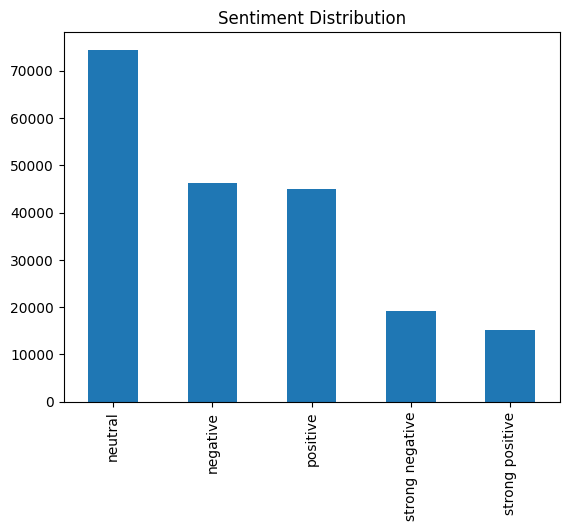

In [ ]:
# Print Sentiment Distribution
print("Sentiment Distribution:")
print(election_df['sentiment_clusters'].value_counts())

# Plot Sentiment Distribution
election_df['sentiment_clusters'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

It looks like most of the tweets are categorized as neutral with positive and negative tweets being split almost evenly.

Next up we will plot the mean sentiment over time for Trump and Biden

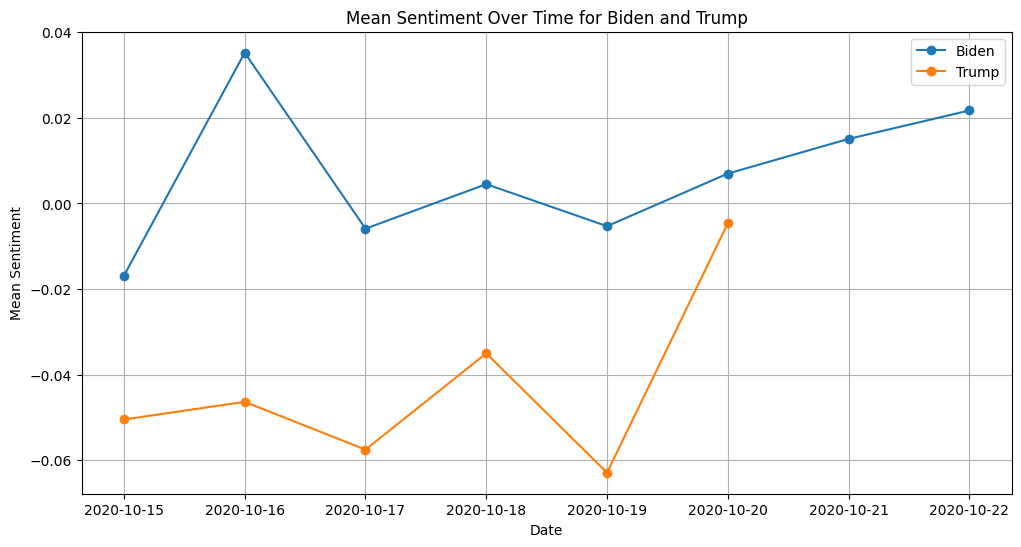

In [ ]:
# Remove rows with non-date values in 'created_at'
election_df = election_df[pd.to_datetime(election_df['created_at'], errors='coerce').notna()]

# Convert 'created_at' to datetime
election_df['created_at'] = pd.to_datetime(election_df['created_at'])

# Group by date and calculate mean sentiment
grouped_data = election_df.groupby(['about', pd.Grouper(key='created_at', freq='D')])['sentiment'].mean().reset_index()

# Separate data for Biden and Trump
biden_data = grouped_data[grouped_data['about'] == 'Biden']
trump_data = grouped_data[grouped_data['about'] == 'Trump']

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(biden_data['created_at'], biden_data['sentiment'], label='Biden', marker='o')
plt.plot(trump_data['created_at'], trump_data['sentiment'], label='Trump', marker='o')

plt.title('Mean Sentiment Over Time for Biden and Trump')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.show()

Okay so it seems that positive and negative tweets cancel eachother out since they are balanced as we saw previously, but for the data we have available here which is around two weeks before the elections we observe that Biden has a slight advantage over Trump.

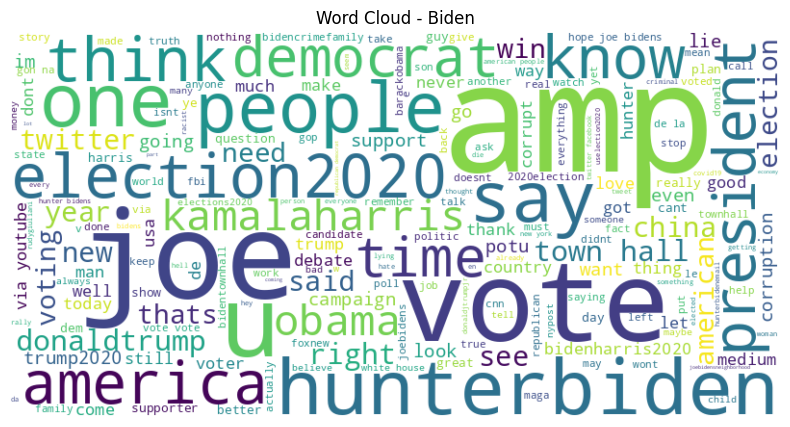

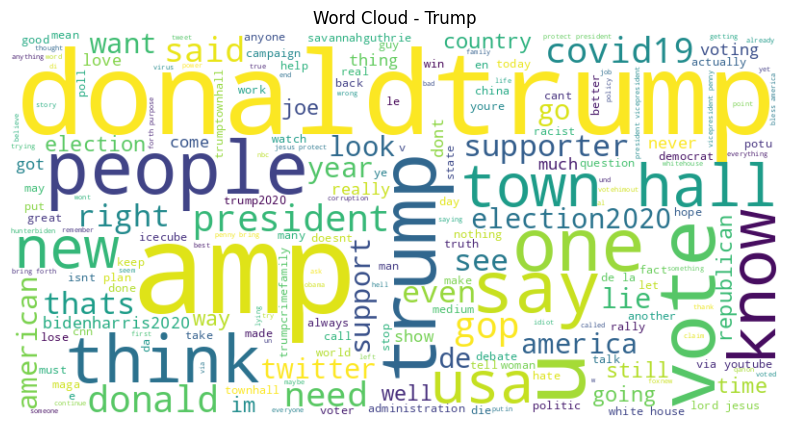

In [ ]:
def preprocess_text(text, exclude_words=[]):
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords and excluded words
    stop_words = set(stopwords.words("english"))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in exclude_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return " ".join(lemmatized_words)


exclude_words = ["joebiden", "biden", 'joe biden', 'Trump','trump', 'Donald Trump', 'DonaldTrump','realdonaldtrump']
election_df['processed_text_2'] = election_df['processed_text'].apply(lambda x: preprocess_text(x, exclude_words=exclude_words))

# Generate word clouds for each value in the "about" column
for about_value in election_df['about'].unique():
    about_text = " ".join(election_df[election_df['about'] == about_value]['processed_text_2'])
    generate_wordcloud(about_text, f"Word Cloud - {about_value}")

We see a big word for Hunter Biden, Joe Biden's son, we will use the spark df we created to search for tweets about him.

In [ ]:
# Register the Spark DataFrame as a temporary SQL table
analyzed_tweets_df.createOrReplaceTempView("election_tweets_table")

# Increase the number of rows displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 100)

# Set the column width for the 'text' column (adjust the value as needed)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)

# Run SQL queries on the Spark DataFrame
query_result = spark.sql("SELECT tweet, sentiment FROM election_tweets_table WHERE tweet LIKE '%Hunter Biden%'")

# Show the result of the query
query_result.show(50, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|tweet                                                                                                                                                                                                                                                                                                                                  |sentiment|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

So it seems here that Joe Biden and Hunter Biden are accused of corruption, with a lot of the tweets classified with a negative value having a high negative score.

Next up lets plot the sentiment over the US states that we have available in our data

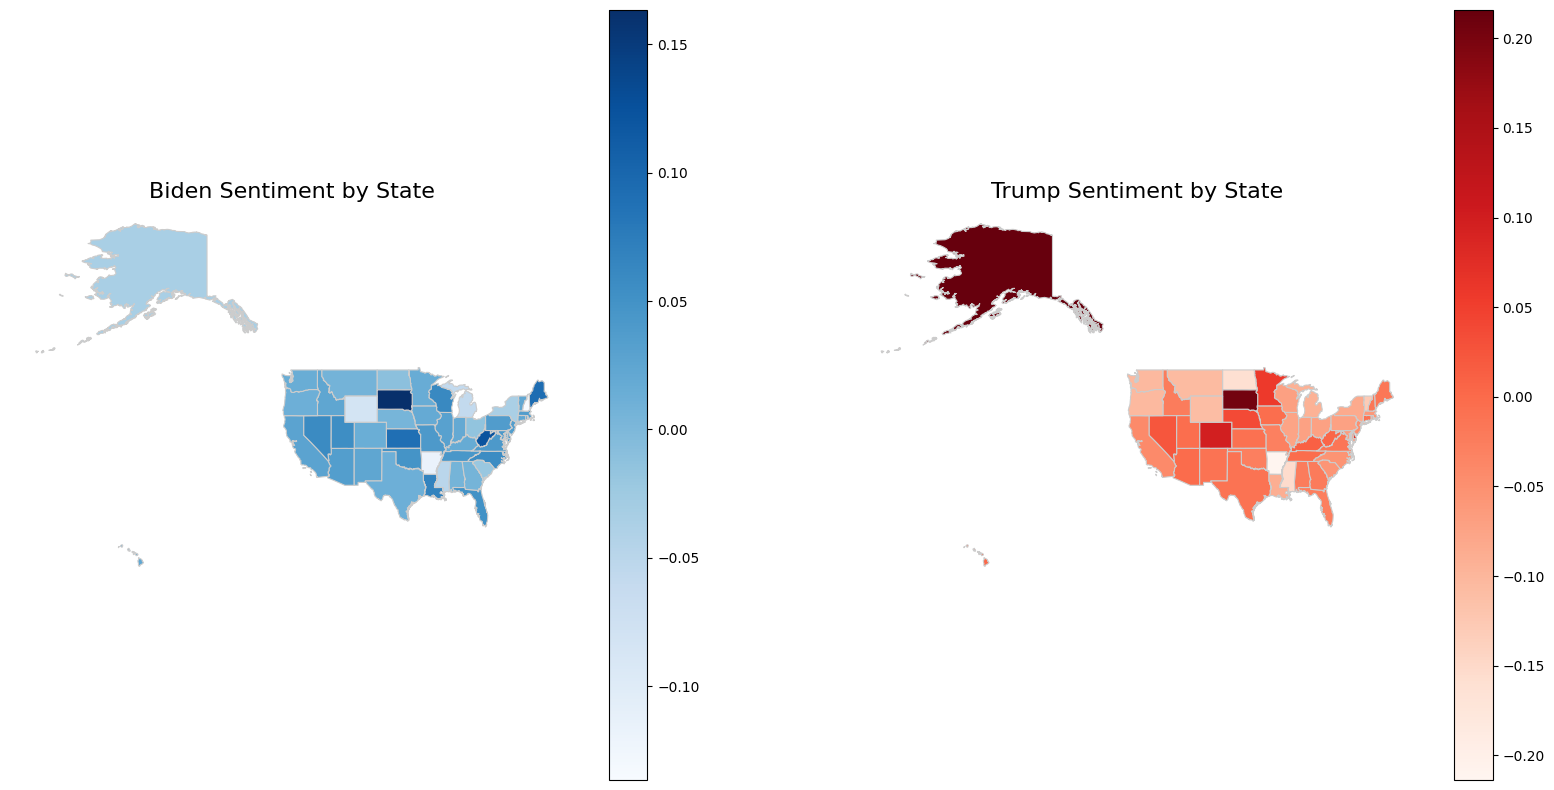

In [ ]:
# Step 1: Filter data to keep only rows where 'state' and 'about' are not null
filtered_data = election_df[(election_df['state'].notnull()) & (election_df['about'].notnull())]

# Step 2: Group data by 'state' and 'about', and calculate the average sentiment
sentiment_by_state = filtered_data.groupby(['state', 'about'])['sentiment'].mean().reset_index()

# Step 3: Load the GeoDataFrame for US states
shapefile_path = Path('/content/States_shapefile.shp')  # Replace with the path to the shapefile
us_states = gpd.read_file(shapefile_path)

# Step 4: Convert 'state' column in election_tweets to uppercase for consistency
election_df['state'] = election_df['state'].str.upper()

# Step 5: Merge sentiment_by_state with us_states GeoDataFrame using 'STATE_NAME' and 'state'
merged_data = us_states.merge(sentiment_by_state, left_on='State_Name', right_on='state', how='left')

# Step 6: Visualize the choropleth map for Biden's sentiment
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Assuming 'about' column has values 'Biden' and 'Trump'
biden_data = merged_data[merged_data['about'] == 'Biden']
biden_data.plot(column='sentiment', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title('Biden Sentiment by State', fontsize=16)
ax[0].set_axis_off()

trump_data = merged_data[merged_data['about'] == 'Trump']
trump_data.plot(column='sentiment', cmap='Reds', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title('Trump Sentiment by State', fontsize=16)
ax[1].set_axis_off()

plt.show()


Both candidates look like they have the same with some differences, e.g Biden is stronger in West Virginia and Trump is stronger in Alaska

## Final Report

In this notebook we took advantage of google cloud to load tweet data in Firestore as individual documents. We also connected to google cloud to retrieve these documents and load them into a Pandas Dataframe and a Spark Dataframe.

Loading these big datasets to Firestore was a difficult and long process because we had to iterate every each one of the rows, we also ran into errors multiple times because the uploading loop just stopped workig after a few thousands iterations. So we uploaded as many as possible.

For the modeling part, we used VADER as it produced the best results and not a custom model as we initially wanted. The idea behind that is that since we do not have a lot of tweets then we needed a robust model.

Concluding, we find that a useful analysis on tweets would require a lot more data than the data we used in this project. The starting goal was to analyze sentiment before big events, but the data did not provide such information, tweets on certain movies for example on the general tweets datasets were too few to come to a conclusion about people's overall sentiment. So o more general analysis was done.